# Data description & Problem statement: 
Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a Regression problem. The data has 8523 rows of 12 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train the Deep Neural Network model by Keras/Tensorflow
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Big mart sales/Train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Weight' ], axis=1, inplace=True)

df['Item_Fat_Content']=df['Item_Fat_Content'].map({'Low Fat':'L', 'low fat':'L', 'LF':'L', 'Regular':'R', 'reg':'R'})

df.head(3)

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,L,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,R,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,L,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [3]:
df.loc[df['Outlet_Establishment_Year']== 1998]= df.loc[df['Outlet_Establishment_Year'] == 1998].fillna('small')

df.dropna(axis=0, inplace=True)
df.shape

(6668, 9)

In [4]:
L_con=['Item_Visibility', 'Item_MRP' ]
L_cat=['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
L_nom=['Item_Fat_Content', 'Item_Type', 'Outlet_Establishment_Year']

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in L_cat:
    encode_text_index(df, i)
    
for i in L_nom:
    encode_text_index(df, i)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['Item_Type']:
    encode_text_dummy(df, name)

In [5]:
X=df.drop(['Item_Outlet_Sales'], axis=1)
y=np.sqrt(df['Item_Outlet_Sales'])

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [17]:
# Keras Neural Networks: ___________________
n_input=X.shape[1]

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

model=Sequential()
model.add(Dense(100, activation="relu", input_shape=(n_input, )))
model.add(Dropout(0.1))
model.add(Dense(100, activation="linear"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

monitor=EarlyStopping(monitor='r2_score', min_delta=0.001, patience=2, mode="auto")
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

history=model.fit(X_train,y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer],  verbose=0)
model.load_weights('best_weights.hdf5') # load weights from best model

model.load_weights('best_weights.hdf5') # load weights from best model
print("Training R^2 score = ", metrics.r2_score(y_train, model.predict(X_train)),"\n")
print("Test R^2 score = ", metrics.r2_score(y_test, model.predict(X_test)) ,"\n")

Training R^2 score =  0.7081027349900558 

Test R^2 score =  0.6905709884953565 



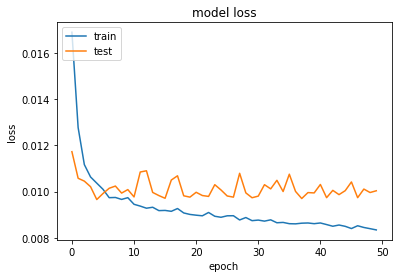

In [18]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

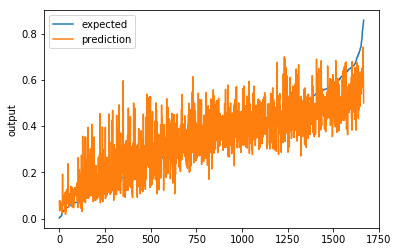

In [19]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=model.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(pd.DataFrame(y_test))

rmse = sqrt(mean_squared_error(y_test_inv**2, pred_inv**2))
print('Test rmse: ', rmse)

Test rmse:  1121.0710395784722


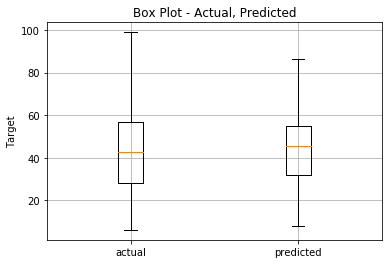

In [21]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

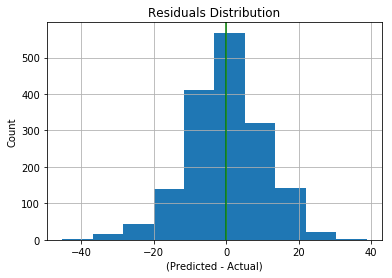

In [22]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()